Available devices:
1. nfet3_01v8_lvt
2. nfet3_01v8_svt
3. nfet_g5v0d10v5
4. pfet3_01v8_hvt
5. pfet3_01v8_lvt
6. pfet3_01v8_svt
7. pfet_g5v0d10v5


Select a device by entering its number:  2


Selected Device: nfet3_01v8_svt
Using file pattern: gmid_nmos_{i}_nfet_01v8_svt_tb.txt
Data loaded for device: C:\Users\NITHIN P\Downloads\SKY130\nfet3_01v8_svt
Length of vgs: 13
Length of gm_id: 13
Length of labels: 13


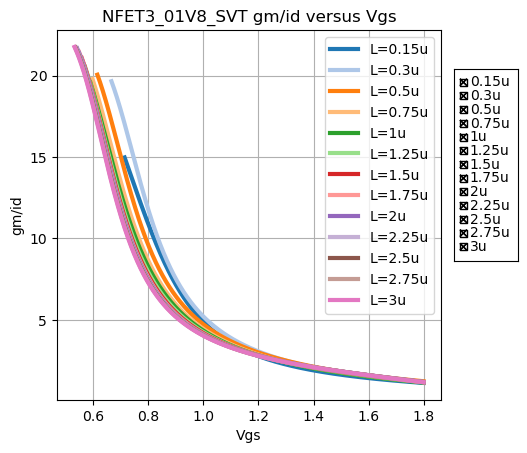

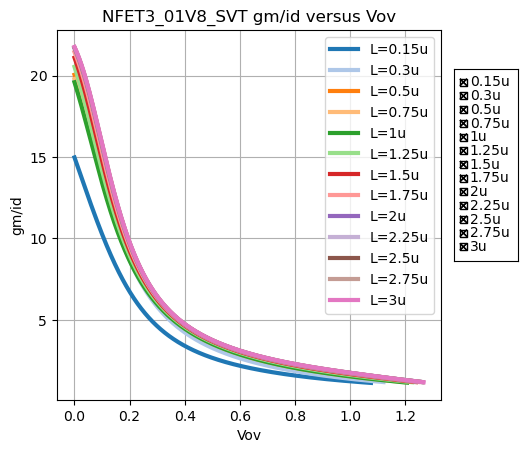

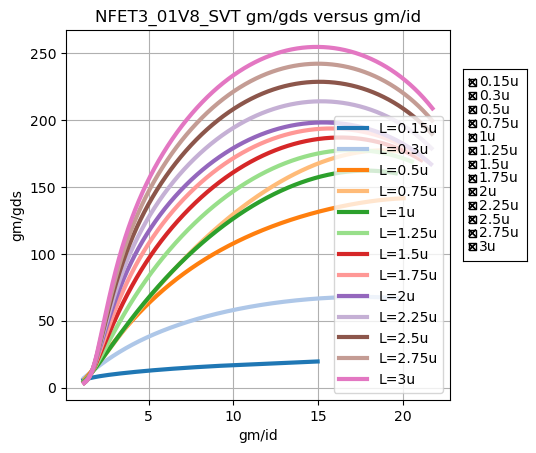

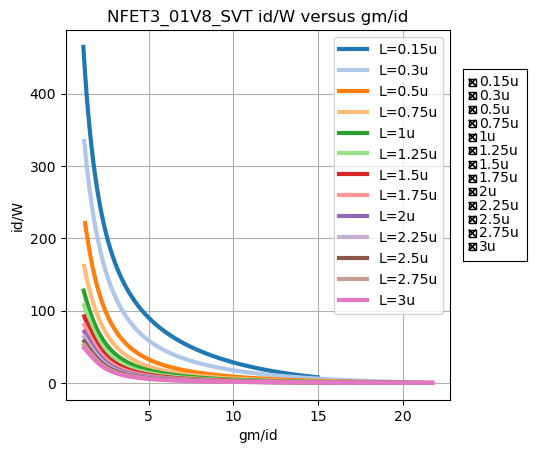

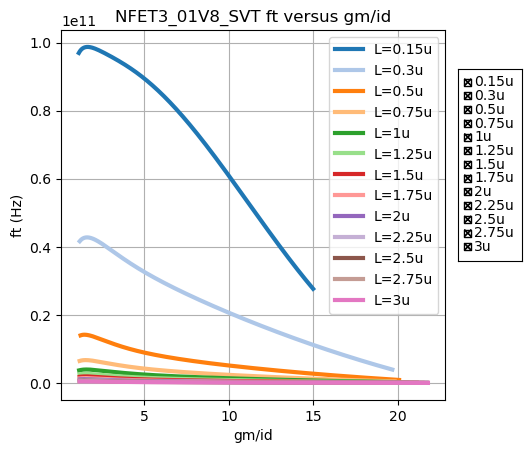

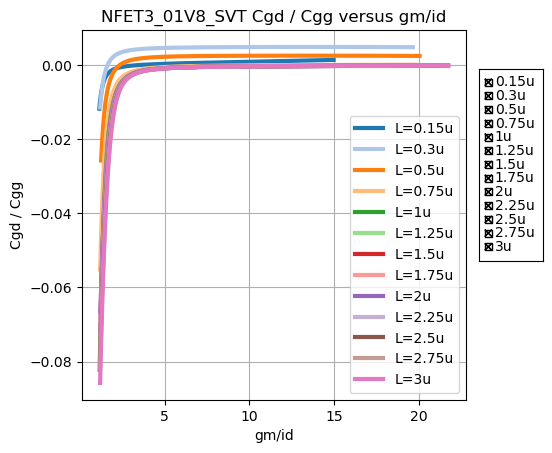

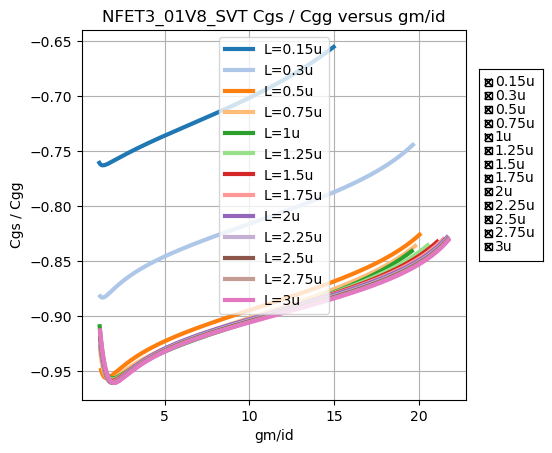

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import CheckButtons

# Define base directory
base_dir = r"C:\Users\NITHIN P\Downloads\SKY130"

# Get available devices (folders)
device_options = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Mapping from folder name to filename pattern
device_file_mapping = {
    "nfet3_01v8_svt": "gmid_nmos_{i}_nfet_01v8_svt_tb.txt",
    "nfet3_01v8_lvt": "gmid_nmos_{i}_nfet_01v8_lvt_tb.txt",
    "nfet3_01v8_hvt": "gmid_nmos_{i}_nfet_01v8_hvt_tb.txt",
    "pfet3_01v8_svt": "gmid_pmos_{i}_pfet_01v8_svt_tb.txt",
    "pfet3_01v8_lvt": "gmid_pmos_{i}_pfet_01v8_lvt_tb.txt",
    "pfet3_01v8_hvt": "gmid_pmos_{i}_pfet_01v8_hvt_tb.txt",
    "nfet_g5v0d10v5": "gmid_nmos_{i}_nfet_g5v0d10v5_tb.txt",
    "pfet_g5v0d10v5": "gmid_pmos_{i}_pfet_g5v0d10v5_tb.txt",
}

# Function to display device options and get user input
def select_device():
    print("Available devices:")
    for idx, device in enumerate(device_options, start=1):
        print(f"{idx}. {device}")
    
    while True:
        try:
            choice = int(input("Select a device by entering its number: "))
            if 1 <= choice <= len(device_options):
                return device_options[choice - 1]
            else:
                print("Invalid choice. Please enter a valid number.")
        except ValueError:
            print("Invalid input. Please enter a number.")

# Function to update path
def update_path(device):
    global path, file_pattern
    path = os.path.join(base_dir, device)
    file_pattern = device_file_mapping.get(device, None)

    if file_pattern:
        print(f"Selected Device: {device}")
        print(f"Using file pattern: {file_pattern}")
        load_data()
    else:
        print(f"Error: No file mapping found for {device}")

# Function to load data
def load_data():
    global vgs, gm_id, gm_gds, id_W, ft, cgd_cgg, cgs_cgg, Vov
    num_files = 13  # Number of transistor lengths

    # Initialize empty lists
    vgs = [[] for _ in range(num_files)]
    gm_id = [[] for _ in range(num_files)]
    gm_gds = [[] for _ in range(num_files)]
    id_W = [[] for _ in range(num_files)]
    ft = [[] for _ in range(num_files)]      
    cgd_cgg = [[] for _ in range(num_files)] 
    cgs_cgg = [[] for _ in range(num_files)]
    Vov = [[] for _ in range(num_files)]  
    W = 2e-6  # SKY130 Width

    if not file_pattern:
        print("Error: No valid file pattern set.")
        return

    for i in range(1, num_files + 1):  # File indices start from 1
        filename = os.path.join(path, file_pattern.format(i=i))
        
        try:
            with open(filename, 'r') as fID:
                for line in fID:
                    try:
                        temp = list(map(float, line.strip().split()))
                        if len(temp) >= 14:  
                            Vgs, gm, _, id_val, _, Vth, _, gds, _, Cgg, _, Cgs, _, Cgd = temp
                            
                            vov_value = Vgs - Vth
                            if vov_value > 0:  
                                vgs[i-1].append(Vgs)
                                Vov[i-1].append(vov_value)
                                gm_id[i-1].append(gm / id_val)
                                gm_gds[i-1].append(gm / gds)
                                id_W[i-1].append(id_val / W)
                                ft[i-1].append(gm / (2 * np.pi * Cgg))
                                cgd_cgg[i-1].append(Cgd / Cgg)
                                cgs_cgg[i-1].append(Cgs / Cgg)
                    except ValueError as e:
                        print(f"Warning: Skipping line in {filename} due to error: {e}")
        except FileNotFoundError:
            print(f"Error: File {filename} not found.")

    print(f"Data loaded for device: {path}")

# Labels for different transistor lengths
labels = ['0.15u', '0.3u', '0.5u', '0.75u', '1u', '1.25u', '1.5u', '1.75u', '2u', '2.25u', '2.5u', '2.75u', '3u']  # SKY130 Lengths

# Function to auto-scale the axes based on visible lines and add margin
def autoscale_lines(ax, lines, margin=0.05):
    x_data = []
    y_data = []

    # Collect data from visible lines
    for line in lines:
        if line.get_visible():
            x_data.extend(line.get_xdata())
            y_data.extend(line.get_ydata())

    if x_data and y_data:  # If there is visible data
        x_min, x_max = min(x_data), max(x_data)
        y_min, y_max = min(y_data), max(y_data)

        # Add margin (percentage of the range)
        x_margin = (x_max - x_min) * margin
        y_margin = (y_max - y_min) * margin

        ax.set_xlim(x_min - x_margin, x_max + x_margin)
        ax.set_ylim(y_min - y_margin, y_max + y_margin)
    else:  # Default to a small range if no data is visible
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

# Function to plot with checkboxes for toggling visibility
def plot_with_checkboxes(x_data, y_data, x_label, y_label, title, min_length):
    fig, ax = plt.subplots()
    plt.subplots_adjust(left=0.2, right=0.8)  # Adjust for space for checkboxes

    # Use a more varied colormap for better visibility
    colormap = plt.get_cmap('tab20')  # Using 'tab20' colormap for distinct colors

    # Plot lines
    lines = []
    for i in range(min_length):
        line, = ax.plot(x_data[i], y_data[i], linestyle='-', color=colormap(i), linewidth=3, label=f"L={labels[i]}")
        lines.append(line)

    # Set labels, title, and grid
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.grid(True)
    ax.legend()

    # Add checkboxes
    rax = plt.axes([0.82, 0.4, 0.1, 0.4])
    visibility = [True] * min_length  # Initialize all to be visible
    check = CheckButtons(rax, labels, visibility)

    # Function to handle checkbox toggle and auto-scale
    def toggle_lines(label):
        index = labels.index(label)
        lines[index].set_visible(not lines[index].get_visible())
        autoscale_lines(ax, lines)  # Auto-scale after toggling
        plt.draw()

    check.on_clicked(toggle_lines)

    # Initial auto-scaling
    autoscale_lines(ax, lines)
    plt.show()

# Main program
if __name__ == "__main__":
    selected_device = select_device()
    update_path(selected_device)

    # Debugging: Print lengths of data arrays
    print(f"Length of vgs: {len(vgs)}")
    print(f"Length of gm_id: {len(gm_id)}")
    print(f"Length of labels: {len(labels)}")

    # Make sure all data lists and labels have the same length
    min_length = min(len(vgs), len(gm_id), len(gm_gds), len(id_W), len(ft), len(cgd_cgg), len(cgs_cgg), len(Vov), len(labels))

    # Extract device name for titles
    device_name = selected_device.upper()  # Convert to uppercase for consistency

    # Plot gm/id versus Vgs
    plot_with_checkboxes(vgs, gm_id, 'Vgs', 'gm/id', f'{device_name} gm/id versus Vgs', min_length)

    # Plot gm/id versus Vov
    plot_with_checkboxes(Vov, gm_id, 'Vov', 'gm/id', f'{device_name} gm/id versus Vov', min_length)

    # Plot gm/gds versus gm/id
    plot_with_checkboxes(gm_id, gm_gds, 'gm/id', 'gm/gds', f'{device_name} gm/gds versus gm/id', min_length)

    # Plot id/W versus gm/id
    plot_with_checkboxes(gm_id, id_W, 'gm/id', 'id/W', f'{device_name} id/W versus gm/id', min_length)

    # Plot ft = gm / Cgg versus gm/id
    plot_with_checkboxes(gm_id, ft, 'gm/id', 'ft (Hz)', f'{device_name} ft versus gm/id', min_length)

    # Plot Cgd / Cgg versus gm/id
    plot_with_checkboxes(gm_id, cgd_cgg, 'gm/id', 'Cgd / Cgg', f'{device_name} Cgd / Cgg versus gm/id', min_length)

    # Plot Cgs / Cgg versus gm/id
    plot_with_checkboxes(gm_id, cgs_cgg, 'gm/id', 'Cgs / Cgg', f'{device_name} Cgs / Cgg versus gm/id', min_length)